In [24]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import keras

In [0]:
import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/comp/train.csv")
df = df.loc[(df['Category'] >= 35)]

In [27]:
df = df.drop(["itemid","image_path"],axis=1)
df.head()

,title,Category
506291,samsung caramel gt e1272 dual sim 32mb black,35
506293,blackberry torch 1 9800 gsm garansi distributo...,36
506298,lenovo a 6000 se 1 16 white,37
506300,keypad blackberry 9360 hitam,36
506306,nokia 230 garansi resmi 1 tahun new,38


In [0]:
import string
import re

word_dict = dict()

def add_word_dict(y):
  for w in y.split():
    if not w in word_dict:
      word_dict[w] = 1
    else:
      word_dict[w] += 1

def remove_row(y):
  processed = re.sub('[^a-zA-Z ]', '', y)
  y = change_punc(y)
  temp = []
  for x in y.split():
    x = remove_digit(x)
    x = reduce_lengthening(x)
    if len(x) > 1: 
      temp.append(x)
  clean = ' '.join(temp)
  clean = re.sub(' {2,}', ' ', clean)
  return(clean.strip())

def remove_digit(w):
  result = ''.join([i for i in w if not i.isdigit()])
  return result
#   table = result.maketrans({key: None for key in string.punctuation})
#   result = result.translate(table)
def change_punc(result):
  clean = re.sub(r"[,.;:@#?!%&$+-]+\ *", " ", result)
  return clean
def reduce_lengthening(text):
  pattern = re.compile(r"(.)\1{2,}")
  return pattern.sub(r"\1\1", text)

In [0]:
def mobile(x):
  if(int(x)!=35):
    return 0
  else:
    return 1

In [0]:
#data cleaning for each row
df["title"] = df["title"].apply(remove_row)
df["Category"] = df["Category"].apply(mobile)

In [31]:
df.head()

,title,Category
506291,samsung caramel gt dual sim mb black,1
506293,blackberry torch gsm garansi distributor tahun...,0
506298,lenovo se white,0
506300,keypad blackberry hitam,0
506306,nokia garansi resmi tahun new,0


In [32]:
all_words = set()

def word_set(y):
  for word in y.split():
    if word not in all_words:
      all_words.add(word)

df["title"].apply(word_set)
print(len(all_words))

10131


In [33]:
length_list = []
for l in df.title:
  length_list.append(len(l.split(" ")))
input_max_len = np.max(length_list)
print(input_max_len)

19


In [34]:
input_words = sorted(list(all_words))
num_encoder_tokens = len(input_words) + 1
input_token_index = dict([(word,i+1) for i, word in enumerate(input_words)])
input_token_index["<blank>"] = 0
print(input_token_index)

{'aa': 1, 'aac': 2, 'aak': 3, 'aap': 4, 'aapba': 5, 'aaus': 6, 'ab': 7, 'abadi': 8, 'abang': 9, 'abbit': 10, 'abc': 11, 'abca': 12, 'abis': 13, 'abizz': 14, 'abk': 15, 'abl': 16, 'abn': 17, 'abpa': 18, 'abr': 19, 'abs': 20, 'absee': 21, 'absen': 22, 'absensi': 23, 'absolut': 24, 'absolute': 25, 'abtu': 26, 'abtx': 27, 'abu': 28, 'ac': 29, 'acast': 30, 'acb': 31, 'acc': 32, 'acce': 33, 'accent': 34, 'accer': 35, 'acces': 36, 'accesiories': 37, 'accesories': 38, 'accesoris': 39, 'access': 40, 'accessories': 41, 'ace': 42, 'acej': 43, 'acer': 44, 'acerliquidm': 45, 'acg': 46, 'ach': 47, 'aclik': 48, 'acmic': 49, 'aconia': 50, 'acpl': 51, 'acrylic': 52, 'action': 53, 'actioncamera': 54, 'actionfit': 55, 'activ': 56, 'activated': 57, 'active': 58, 'activity': 59, 'actu': 60, 'actuator': 61, 'acu': 62, 'acxg': 63, 'acyrilic': 64, 'ad': 65, 'ada': 66, 'adabonus': 67, 'adalah': 68, 'adapt': 69, 'adapter': 70, 'adapterpin': 71, 'adaptive': 72, 'adaptor': 73, 'adaptore': 74, 'adata': 75, 'adavan

In [0]:
df = df.sample(frac=1.)

In [0]:
input_data = np.zeros(
(len(df.title),input_max_len),dtype="float32")
target_data = df["Category"].values

In [0]:
for i,input_text in enumerate(df.title):
  for t,word in enumerate(input_text.split()):
    input_data[i,t] = input_token_index[word]

In [0]:
embedding_size = 100

from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

In [0]:
def generate_embedding_matrix(w2v_path1,w2v_path2, dec_map, lang_dim = 100):
  embeddings_index1 = {}
  embeddings_index2 = {}
  f1 = open (w2v_path1,"r",encoding = "utf-8")
  f2 = open (w2v_path2,"r",encoding = "utf-8")
  for line in f1:
    values = line.split()
    word= values[0]
    coefs = np.asarray(values[1:],dtype="float32")
    embeddings_index1[word] = coefs
  f1.close()
  for line in f2:
    values = line.split()
    word= values[0]
    coefs = np.asarray(values[1:],dtype="float32")
    embeddings_index2[word] = coefs
  f2.close()
  #prepare embedding_matrix
  embedding_matrix = np.random.rand(len(dec_map),lang_dim)
  for idx, wd in dec_map.items():
    if wd in embeddings_index1.keys():
      embedding_matrix[idx] = embeddings_index1[wd]
    elif (wd in embeddings_index2.keys()):
      embedding_matrix[idx] = embeddings_index2[wd]
    else:
      continue
  return embedding_matrix

In [47]:
idx2word = {}
for word, index in input_token_index.items():
  idx2word[index] = word
print(len(idx2word))
embedding_matrix = generate_embedding_matrix("/content/gdrive/My Drive/comp/glove.6B.100d.txt","/content/gdrive/My Drive/comp/custom_glove_100d.txt",idx2word)

10132


In [0]:
import pickle
pickle.dump( embedding_matrix, open( "em_is35ornot.p", "wb" ) )

In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten,GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate 
from keras.layers import GRU, Dense, BatchNormalization, Input, Conv1D, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model, load_model

In [48]:
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_acc", verbose = 1,
                              save_best_only = True, mode = "max")
early_stop = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5)

dropout_rate = 0.3
units = 100
inputs = Input(shape=(input_max_len,))
x = Embedding(num_encoder_tokens,embedding_size,weights=[embedding_matrix])(inputs)
x1 =  SpatialDropout1D(dropout_rate)(x)

x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool1_gru = GlobalAveragePooling1D()(x1)
max_pool1_gru = GlobalMaxPooling1D()(x1)

x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool3_gru = GlobalAveragePooling1D()(x3)
max_pool3_gru = GlobalMaxPooling1D()(x3)

x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool1_lstm = GlobalAveragePooling1D()(x1)
max_pool1_lstm = GlobalMaxPooling1D()(x1)

x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool3_lstm = GlobalAveragePooling1D()(x3)
max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
x = BatchNormalization()(x)
x = Dropout(0.2)(Dense(128,activation='relu') (x))
x = BatchNormalization()(x)
x = Dropout(0.2)(Dense(100,activation='relu') (x))
output = Dense(1, activation = "sigmoid")(x)
model = Model(inputs,output)
model.compile(optimizer=Adam(lr = 0.001, decay = 1e-5),loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 19)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 19, 100)      1013200     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 19, 100)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 19, 200)      121200      spatial_dropout1d_1[0][0]   

In [49]:
history = model.fit(input_data,target_data,batch_size=512,epochs=20,validation_split=0.05,verbose = 1, callbacks = [check_point, early_stop])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 79040 samples, validate on 4161 samples
Epoch 1/20
79040/79040 [==============================] - 15s 189us/step - loss: 0.5144 - acc: 0.7646 - val_loss: 0.3921 - val_acc: 0.8476

Epoch 00001: val_acc improved from -inf to 0.84763, saving model to best_model.hdf5
Epoch 2/20
79040/79040 [==============================] - 10s 124us/step - loss: 0.3939 - acc: 0.8484 - val_loss: 0.3571 - val_acc: 0.8613

Epoch 00002: val_acc improved from 0.84763 to 0.86133, saving model to best_model.hdf5
Epoch 3/20
79040/79040 [==============================] - 9s 118us/step - loss: 0.3682 - acc: 0.8581 - val_loss: 0.3442 - val_acc: 0.8630

Epoch 00003: val_acc improved from 0.86133 to 0.86301, saving model to best_model.hdf5
Epoch 4/20
79040/79040 [==============================] - 10s 127us/step - loss: 0.3507 - acc: 0.8644 - val_loss: 0.3404 - val_acc: 0.8654

Epoch 00

In [50]:
history = model.fit(input_data,target_data,batch_size=512,epochs=10,validation_split=0.05,verbose = 1, callbacks = [check_point, early_stop])

Train on 79040 samples, validate on 4161 samples
Epoch 1/10
79040/79040 [==============================] - 10s 128us/step - loss: 0.2277 - acc: 0.9134 - val_loss: 0.3210 - val_acc: 0.8856

Epoch 00001: val_acc did not improve from 0.88705
Epoch 2/10
79040/79040 [==============================] - 9s 118us/step - loss: 0.2237 - acc: 0.9139 - val_loss: 0.3405 - val_acc: 0.8825

Epoch 00002: val_acc did not improve from 0.88705
Epoch 3/10
79040/79040 [==============================] - 10s 125us/step - loss: 0.2196 - acc: 0.9162 - val_loss: 0.3288 - val_acc: 0.8827

Epoch 00003: val_acc did not improve from 0.88705
Epoch 4/10
79040/79040 [==============================] - 9s 118us/step - loss: 0.2150 - acc: 0.9177 - val_loss: 0.3427 - val_acc: 0.8882

Epoch 00004: val_acc improved from 0.88705 to 0.88825, saving model to best_model.hdf5
Epoch 5/10
79040/79040 [==============================] - 10s 121us/step - loss: 0.2114 - acc: 0.9190 - val_loss: 0.3413 - val_acc: 0.8815

Epoch 00005: val

In [0]:
dropout_rate = 0.3
units = 100
inputs = Input(shape=(input_max_len,))
x = Embedding(num_encoder_tokens,embedding_size,weights=[embedding_matrix])(inputs)
x1 =  SpatialDropout1D(dropout_rate)(x)

x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool1_gru = GlobalAveragePooling1D()(x1)
max_pool1_gru = GlobalMaxPooling1D()(x1)

x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool3_gru = GlobalAveragePooling1D()(x3)
max_pool3_gru = GlobalMaxPooling1D()(x3)

x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool1_lstm = GlobalAveragePooling1D()(x1)
max_pool1_lstm = GlobalMaxPooling1D()(x1)

x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool3_lstm = GlobalAveragePooling1D()(x3)
max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
x = BatchNormalization()(x)
x = Dropout(0.2)(Dense(128,activation='relu') (x))
x = BatchNormalization()(x)
x = Dropout(0.2)(Dense(100,activation='relu') (x))
output = Dense(58, activation = "softmax")(x)
model = Model(inputs,output)
model.compile(optimizer= Adam(lr = 0.0005, decay = 1e-6),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()
model = load_model(file_path)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 22, 300)      13902900    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 22, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 22, 200)      241200      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_5 (

In [0]:
history = model.fit(input_data,target_data,batch_size=512,epochs=5,validation_split=0.01,verbose = 1, callbacks = [check_point, early_stop])

Train on 659948 samples, validate on 6667 samples
Epoch 1/5
659948/659948 [==============================] - 76s 115us/step - loss: 0.7939 - acc: 0.7491 - val_loss: 0.8767 - val_acc: 0.7347

Epoch 00001: val_loss did not improve from 0.87412
Epoch 2/5
659948/659948 [==============================] - 74s 113us/step - loss: 0.7842 - acc: 0.7516 - val_loss: 0.8701 - val_acc: 0.7323

Epoch 00002: val_loss improved from 0.87412 to 0.87011, saving model to best_model.hdf5
Epoch 3/5
659948/659948 [==============================] - 76s 115us/step - loss: 0.7756 - acc: 0.7551 - val_loss: 0.8849 - val_acc: 0.7329

Epoch 00003: val_loss did not improve from 0.87011
Epoch 4/5
659948/659948 [==============================] - 76s 115us/step - loss: 0.7671 - acc: 0.7568 - val_loss: 0.8770 - val_acc: 0.7327

Epoch 00004: val_loss did not improve from 0.87011
Epoch 5/5
659948/659948 [==============================] - 76s 115us/step - loss: 0.7596 - acc: 0.7587 - val_loss: 0.8765 - val_acc: 0.7344

Epoc

In [0]:
test_df = pd.read_csv("/content/gdrive/My Drive/comp/test.csv")

In [0]:
test_df.head()

,itemid,title,image_path
0,370855998,flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg
1,637234604,maybelline clear smooth all in one bb cream sp...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg
2,690282890,murah innisfree eco natural green tea bb cream...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg
3,930913462,loreal white perfect day cream spf 17 pa white...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg
4,1039280071,hada labo cc cream ultimate anti aging spf 35 ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg


In [0]:
#data cleaning for each row
test_df["title"] = test_df["title"].apply(remove_row)
test_df = test_df.drop(["image_path"],axis=1)

In [0]:
predict_data = np.zeros(
(len(test_df.title),input_max_len),dtype="float32")

for i,input_text in enumerate(test_df.title):
  t = 0
  for word in input_text.split():
    try:
      predict_data[i,t] = input_token_index[word]
      t +=1
    except:
      pass

In [0]:
predict_data[:4]

array([[13873., 44470.,  8739.,  3239., 38372., 26285.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.],
       [24855.,  7595., 37810.,  1027., 18435., 29146.,  3239.,  8739.,
        38372.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.],
       [27178., 18655., 11382., 27567., 15967., 40189.,  3239.,  8739.,
        38372., 29749., 11659.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.],
       [23511., 44470., 30812.,  9407.,  8739., 38372., 29749., 44493.,
        12491., 41334., 27178.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.]], dtype=float32)

In [0]:
pred = model.predict(predict_data,batch_size = 256)

In [0]:
print(pred.shape)

(172402, 58)


In [0]:
predictions = np.round(np.argmax(pred,axis=1)).astype(int)
print(predictions.shape)

(172402,)


In [0]:
print(predictions[:1000])

[ 5  5  5  4  5  3  4  5  5  5  5  2  3  4  5  5  3  9  5  3  3  3  5  5
  3  5  3  5  4  5  5  5  3  3  5  3  3  3  3  3  3  7  5  3  5  2  3  7
  5  5  3  3  5  5  4  3  3  3  1  3  4  5  5  3  5  3  5  3  4  5  5  5
  5  3  3  3  5  3  3  5  5  5  5  5  3  3  3  1  5  3  5  5  5  3  5  1
  3  3  5  5  5  5  3  5  1  5  3  5  5  5  5  3  5  3  3  3  5  1  3  5
  5  3  5  5  5  5  5  7  5  3  5  3  5  1  5  5  5  5  5  3  5  7  5  4
  3  3  3  5  3  7  3  5  5  7  3  5  5  3  7  5  3  3  1  5  5  5  3  1
  3  5  5  5  5  5  3  5  1  3  3  3  5  5  2  3  3  5  5  3  3  5  5  4
  3  3  5  5  3  5  5  5  5  9  1  3  5  5  4  3  3  3  5  5  5  3  5  5
  3  3  3  5  3  3  3  3  3  5  3  4  4  7  3  5  3  5  5  5  5  5  4  5
  3  3  1  3  5  3  9  5  1  5  5  5  5  5  9  3  4  3  5  5  3  3  5  3
  5  5  5  5  5  5  5  3  3  3  1  5  3  5  5  1  5  3  5  5  5  1  3  5
  5  5  3  3  3  3  3 11  5  7  5  5  5  3  5  5  5  5  5  3  4  5  5  3
  1  4  5  3  5  5  7  5  3  3  3  7  5  3  3  5  5

In [0]:
submit_df = pd.DataFrame([test_df["itemid"], predictions],columns=["itemid","Category"])
submit_df.to_csv("submission.csv", index=False)

In [0]:
from google.colab import files
files.download("submission.csv")

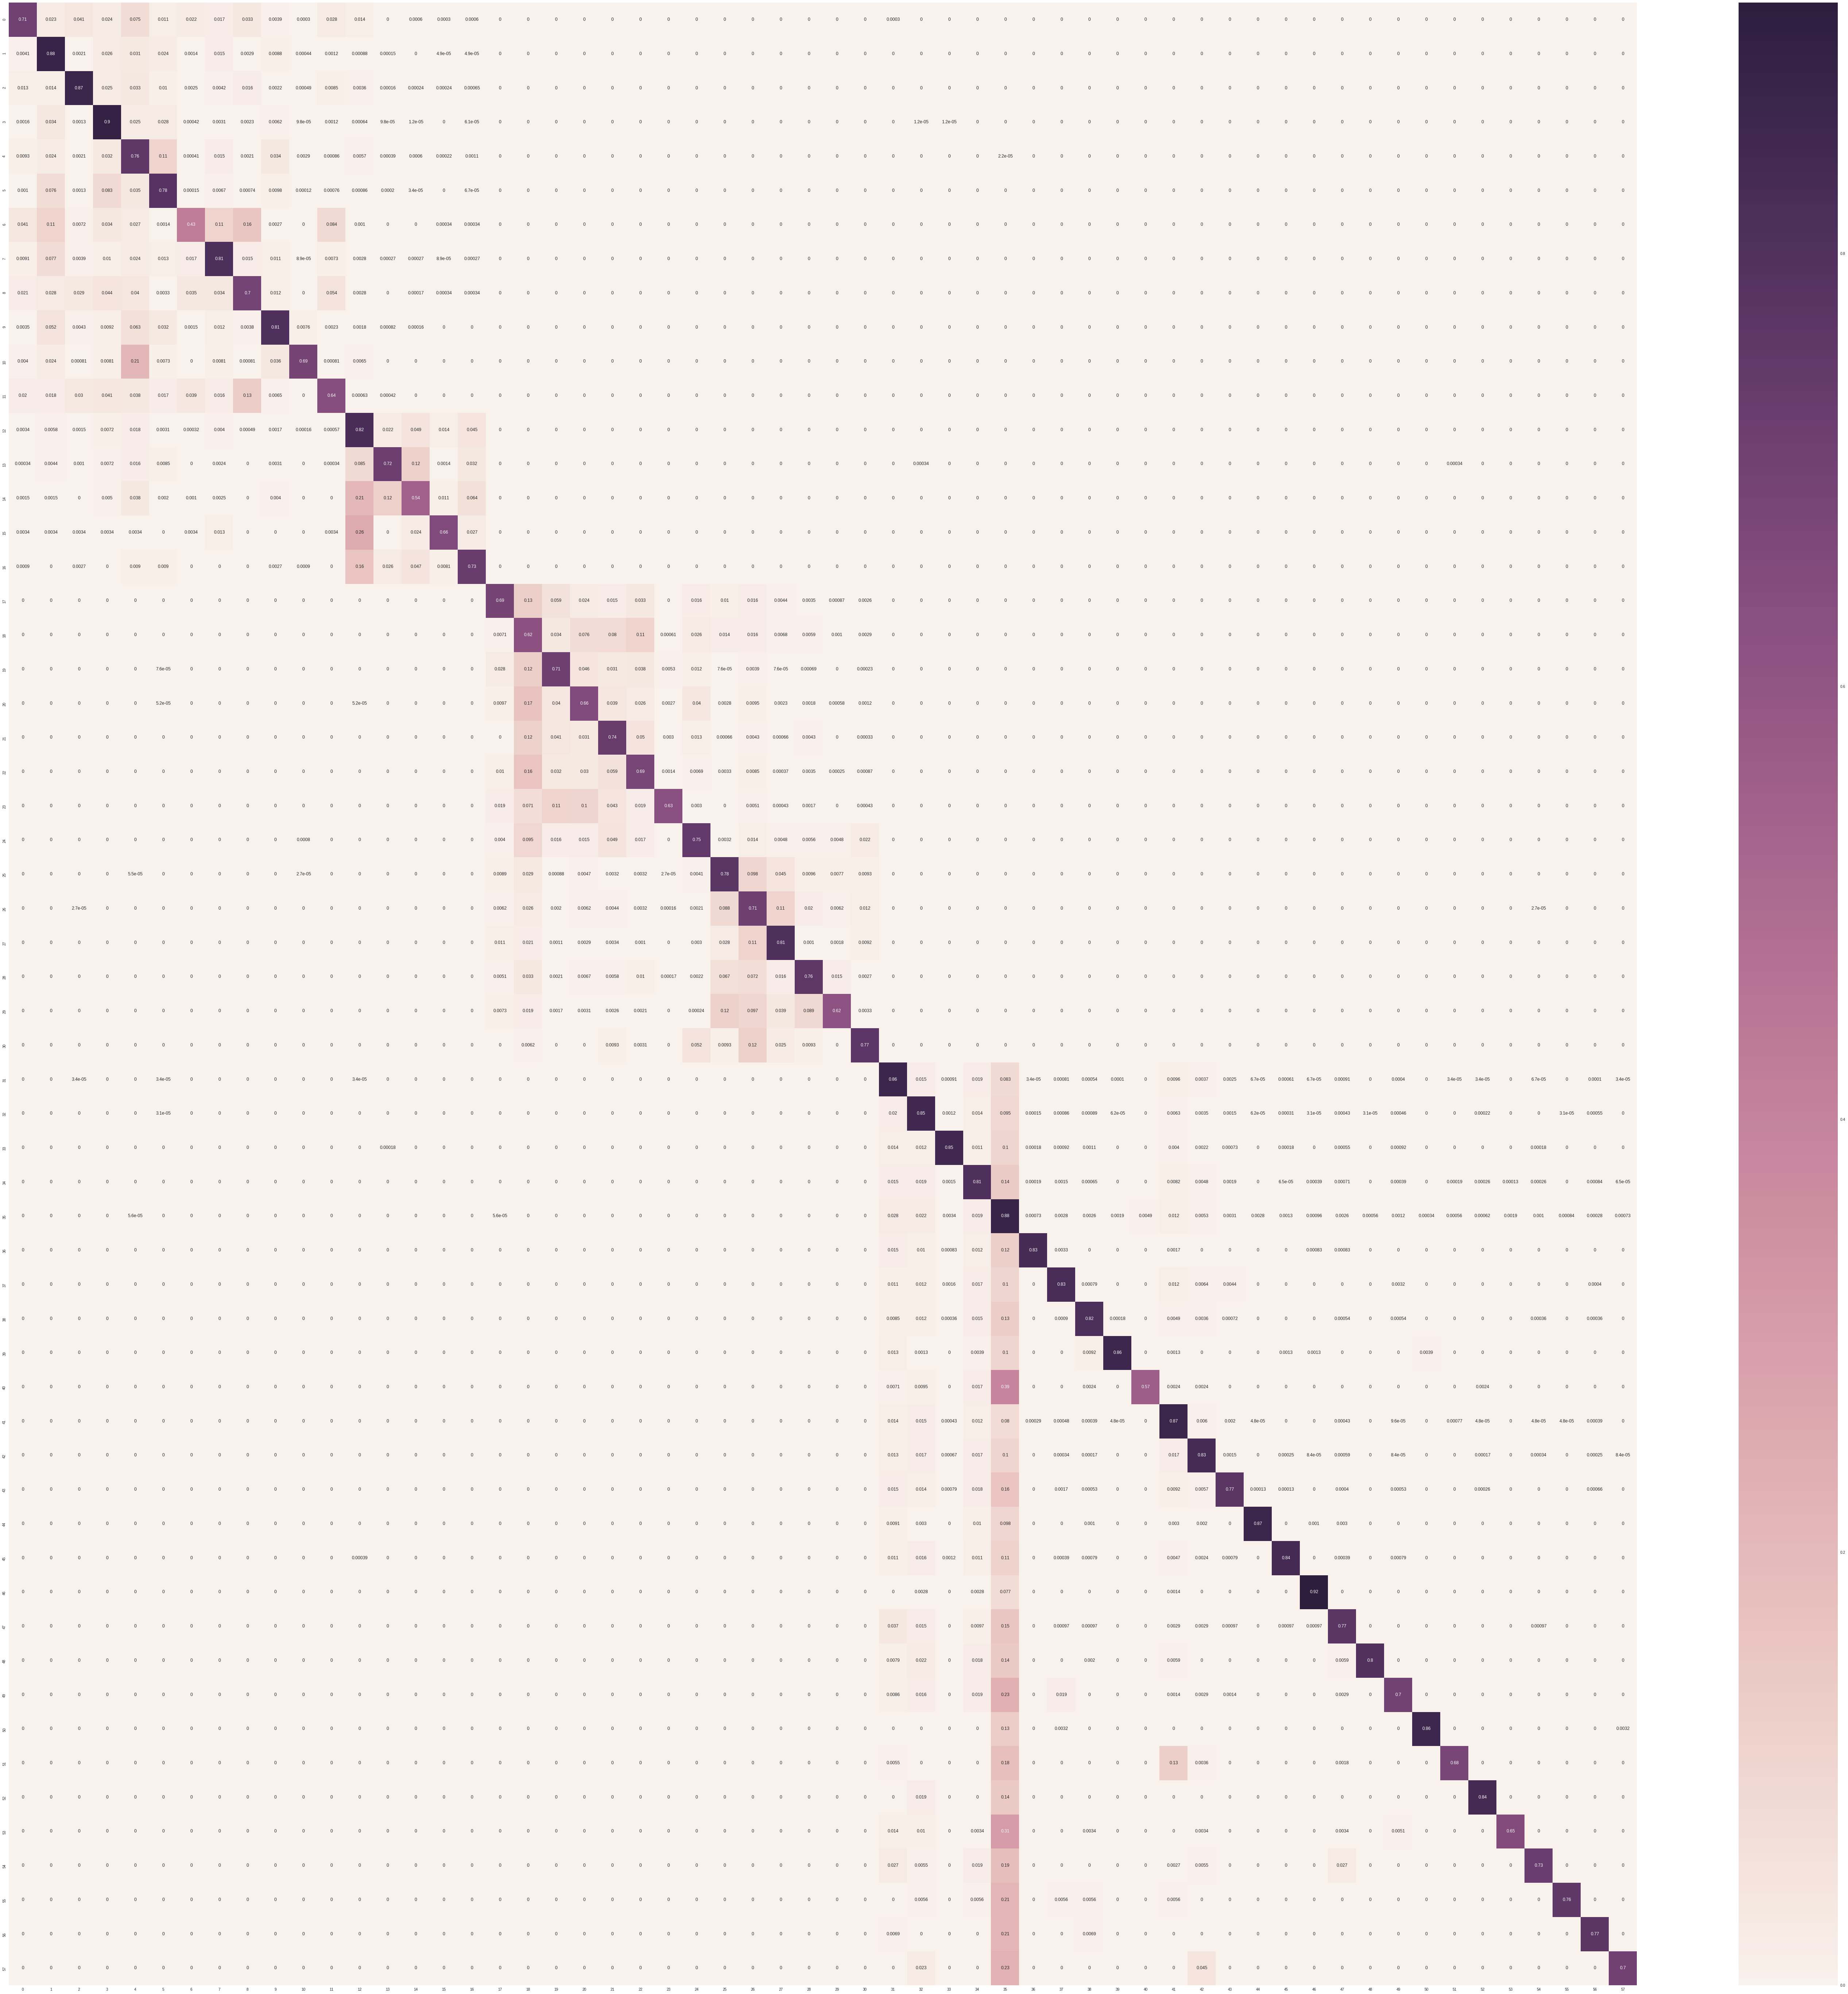

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

train_pred = model.predict(input_data,batch_size = 512)

np.set_printoptions(precision=3)

cm = confusion_matrix(train_pred.argmax(axis=1), target_data)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm, index = range(58),
                      columns = range(58))
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)